In [4]:
from scipy.stats import median_abs_deviation

import sys
sys.path.insert(0, '/home/workspace/mm_analysis')
sys.path.insert(0, '/home/workspace/')

from py_util import *
from utilities import *

hdir = '/home/workspace'
wdir = hdir + "/mm_analysis/EXP-01244"
objdir1 = wdir + "/object_building/objects/"
objdir2 = wdir + "/processing/objects/"
degdir = wdir + "/deg_list/"

raw_adata = sc.read_h5ad(objdir1 + "downsampled_wk2_4_organoids_adata.h5ad")
adata = sc.read_h5ad(objdir2 + "processed_wk2_4_organoids_adata.h5ad")

In [13]:
samples = list(raw_adata.obs['sample_type'].unique())

filtered_adatas = {}

for sample in samples:
    mask = raw_adata.obs['sample_type'] == sample
    sample_adata = raw_adata[mask].copy()
    
    sample_adata.var["mt"] = sample_adata.var_names.str.startswith("MT-")                 # mitochondrial genes
    sample_adata.var["ribo"] = sample_adata.var_names.str.startswith(("RPS", "RPL"))      # ribosomal genes
    sample_adata.var["hb"] = sample_adata.var_names.str.contains(("^HB[^(P)]"))           # hemoglobin genes
    
    sc.pp.calculate_qc_metrics(sample_adata, qc_vars=["mt", "ribo", "hb"], inplace=True, percent_top=[20], log1p=True)
    
    sample_adata.obs["mt_outlier"] = sample_adata.obs['pct_counts_mt'] >= 10

    # Run Scrublet for doublet detection
    scrub = scrublet.Scrublet(sample_adata.X)
    doublet_scores, predicted_doublets = scrub.scrub_doublets(verbose=False)
    
    # Add Scrublet results to cell metadata
    sample_adata.obs['doublet_score'] = doublet_scores
    sample_adata.obs['predicted_doublet'] = predicted_doublets

    # Filtering outliers
    sample_adata = sample_adata[(sample_adata.obs["predicted_doublet"] == False) & (sample_adata.obs["mt_outlier"] == False)].copy()

    filtered_adatas[sample_adata.obs['sample_type'].unique()[0]] = sample_adata.copy()

adata = ad.concat(filtered_adatas.values(), join='outer', merge='same')

# Store log1p transformed normalized counts
sc.pp.normalize_total(adata)
sc.pp.log1p(adata)

# Saving raw adata
adata.raw = adata

# Standard processing workflow
sc.pp.highly_variable_genes(adata)
sc.pp.scale(adata)
sc.pp.pca(adata)

# Harmonizing data based on sample type
X = adata.obsm['X_pca'].astype(np.float64)
harmony_out = hm.run_harmony(X, adata.obs, 'sample_type')
adata.obsm['X_pca'] = harmony_out.Z_corr.T

sc.pp.neighbors(adata)
sc.tl.umap(adata)

# Computing a range of leiden resolutions from 0-2 in increments of 0.1
res_range = np.round(np.arange(0, 2.2, 0.1), 1)
for res in res_range:
    sc.tl.leiden(
        adata,
        flavor="igraph",
        key_added=f"leiden_{str(res).replace('.', '_')}",
        n_iterations=2,
        resolution=res
    )

adata.uns['leiden_ranges'] = [f'leiden_{i:.1f}'.replace('.', '_') for i in np.arange(0, 2.1, 0.1)]

target_leiden = 'leiden_0_8'

sc.tl.paga(adata, groups=target_leiden)
sc.tl.rank_genes_groups(adata, target_leiden, method='wilcoxon', n_genes=20)

adata.write(objdir2 + 'processed_wk2_4_organoids_adata.h5ad', compression='gzip')

2025-02-17 21:25:50,981 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
Computing initial centroids with sklearn.KMeans...
2025-02-17 21:25:54,173 - harmonypy - INFO - sklearn.KMeans initialization complete.
sklearn.KMeans initialization complete.
2025-02-17 21:25:54,256 - harmonypy - INFO - Iteration 1 of 10
Iteration 1 of 10
2025-02-17 21:25:57,356 - harmonypy - INFO - Iteration 2 of 10
Iteration 2 of 10
2025-02-17 21:26:00,528 - harmonypy - INFO - Iteration 3 of 10
Iteration 3 of 10
2025-02-17 21:26:03,795 - harmonypy - INFO - Iteration 4 of 10
Iteration 4 of 10
2025-02-17 21:26:06,955 - harmonypy - INFO - Iteration 5 of 10
Iteration 5 of 10
2025-02-17 21:26:10,090 - harmonypy - INFO - Iteration 6 of 10
Iteration 6 of 10
2025-02-17 21:26:13,285 - harmonypy - INFO - Converged after 6 iterations
Converged after 6 iterations


# Sample Type UMAP

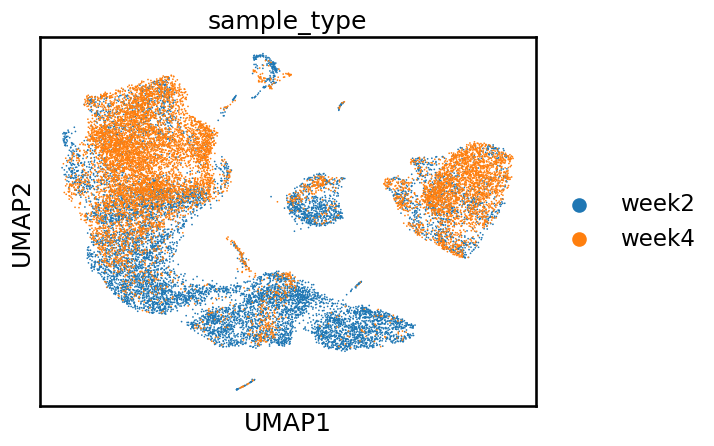

In [7]:
sc.pl.umap(
    adata,
    color='sample_type'
)

# Leiden UMAPs

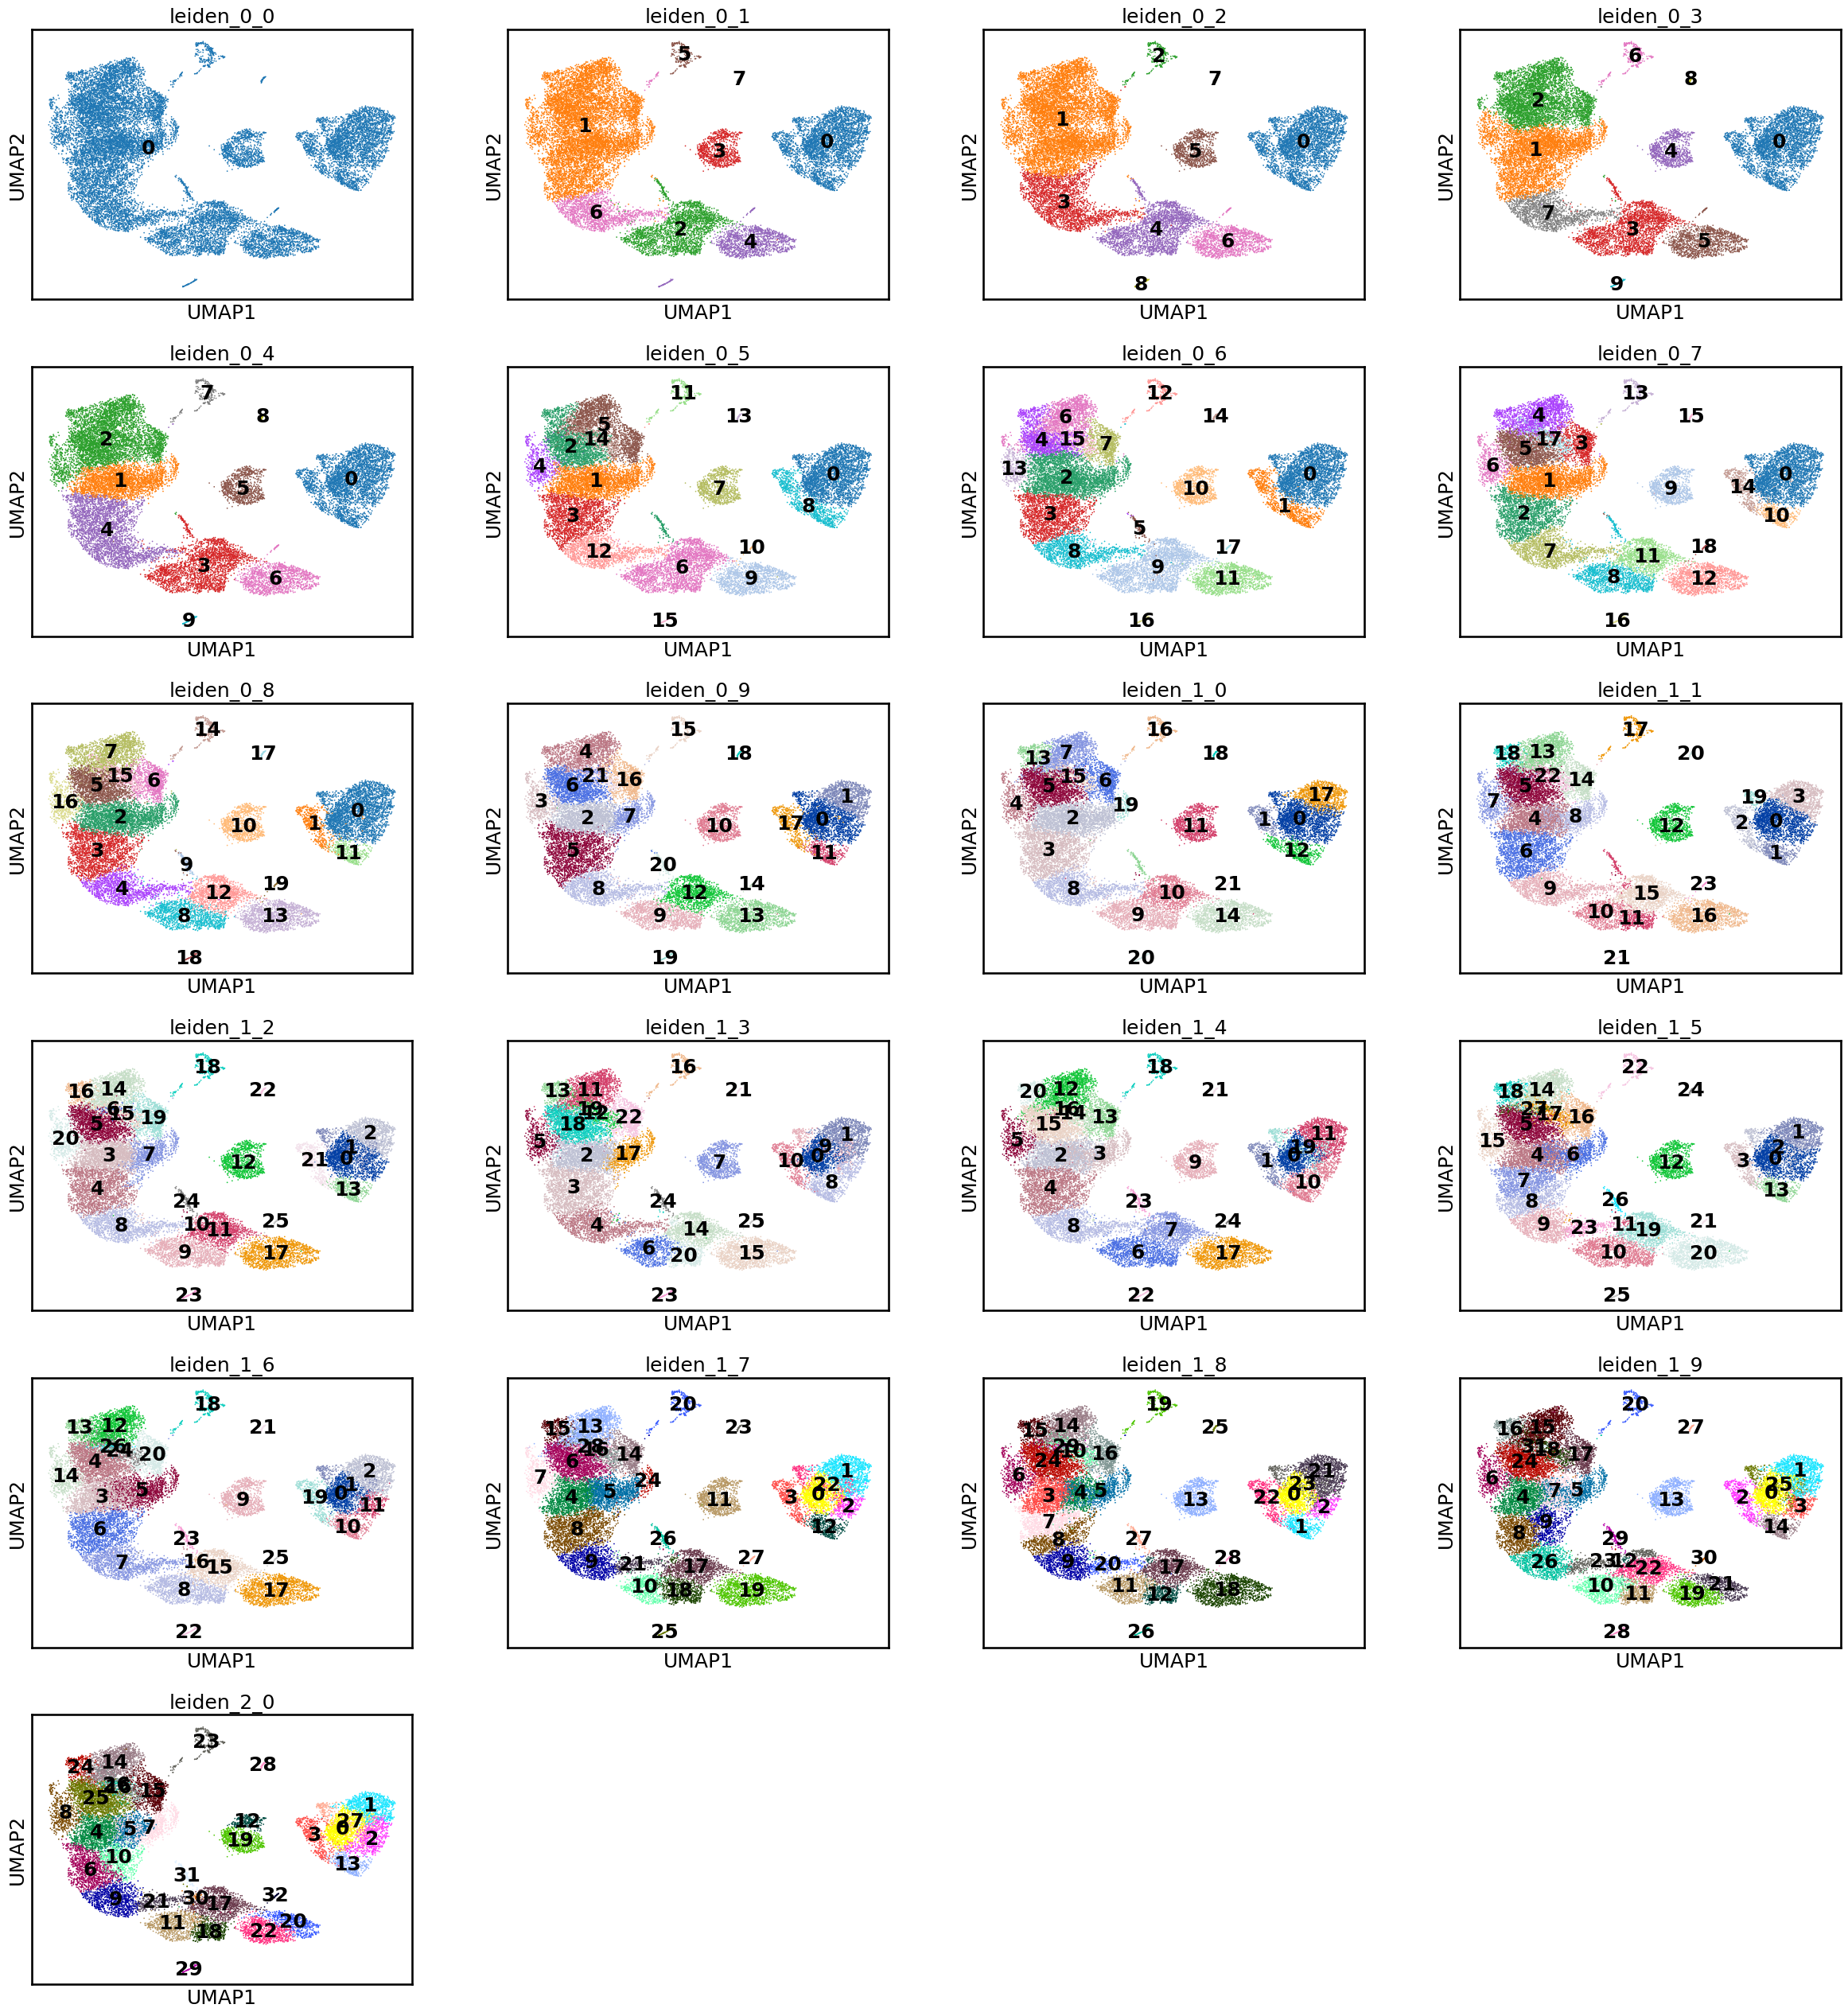

In [8]:
sc.pl.umap(
    adata,
    color=adata.uns['leiden_ranges'],
    legend_loc='on data'
)